# Lab Assignment 7
## Andrew Marquardt

In [55]:
# Import stuff
import cvxpy as cp
import numpy as np
from tclab import TCLab, clock, Historian, Plotter

In [56]:
# copied values
CpH = 8.570225192333513 #Joules/degree C
CpS = 1.1198465579234749 #Joules/degree C
Ua = 0.03916910667788763 #Watts/degree C
Ub = 0.08256218948251515 #Watts/degree C
Uc = 0.03558351485126857 #Watts/degree C
alpha = 0.00016
P1 = 200
P2 = 100

In [57]:
# build operators and vectors
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], 
              [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
              [0, 0, Ub/CpS, -Ub/CpS]])

Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])

Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

# initial values for states and inputs
u_initial = np.array([0, 0])
d_initial = np.array([Tamb])
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])

Feed Forward Function

In [58]:
def feedforward(Tamb,setpts):  # note: setpts must be a list 2 entries long
    # knowns
    d = np.array([Tamb])            # disturbance

    # unknowns to be computed
    u = cp.Variable(2)
    x = cp.Variable(4)
    y = cp.Variable(2)

    # objective
    objective = cp.Minimize(0)

    # model constraints
    model_constraints = [
        0 == A@x + Bu@u + Bd@d,
        y == C@x]

    # input constraints
    input_constraints = [0 <= u, u <= 100]

    # output constraints
    output_constraints = [x <= 60]

    # setpoints
    setpoints = [x[0]==setpts[0],x[2]==setpts[1]]

    # solve problem
    constraints = model_constraints + input_constraints + output_constraints + setpoints
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return u,x,y

In [71]:
# test parameters
t_final = 900
t_step = 2
T_amb = 21.4 # taken from average of heater temperatures right before run
T_target = [45,40]
u_solve,x_solve,y_solve = feedforward(T_amb,T_target)
print(u_solve.value)
print(x_solve.value)

[34.44714037 34.41423812]
[45. 45. 40. 40.]


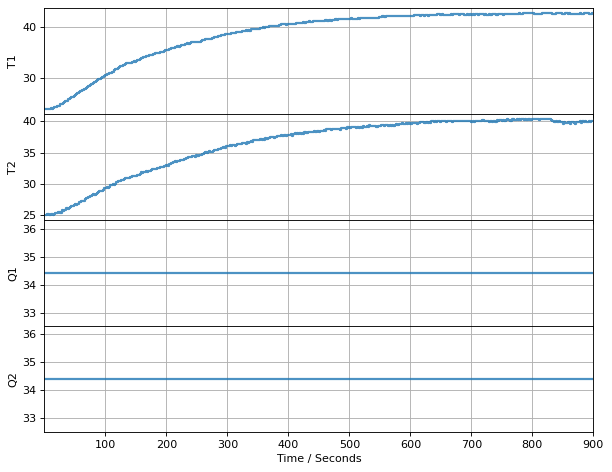

TCLab disconnected successfully.


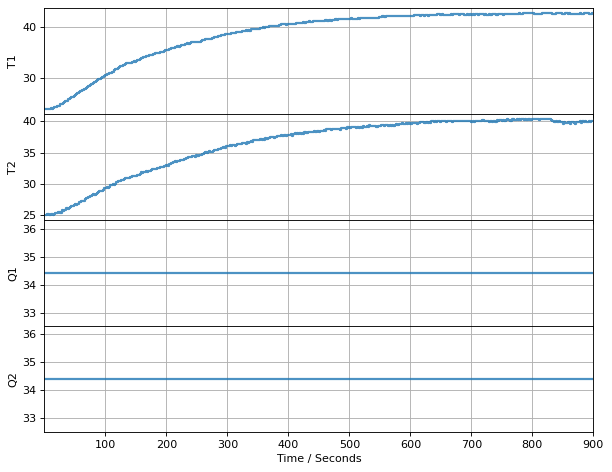

In [81]:
with TCLab() as lab:
    lab.P1 = P1
    lab.P2 = P2
    h = Historian(lab.sources)
    p = Plotter(h,t_final)
    for t in clock(t_final):
        lab.U1 = u_solve.value[0]
        lab.U2 = u_solve.value[1]
        p.update(t)

The prediction was somewhat off from the real outcome, though this could potentially be attributed to differences in the starting temperatures of the heaters.  Overall, the T2 value exceeded, then re-equilibrated with, the desired value, but the T1 value was consistently underperforming by about 3 degrees.  Still, the optimization is a good predictor of the rough behavior of the system.

In [80]:
# code block to determine if heaters have cooled sufficiently to re-run
with TCLab() as lab:
    print(lab.T1)
    print(lab.T2)

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware 3.0.0 Arduino Leonardo/Micro.
23.799
24.927
TCLab disconnected successfully.


In [52]:
def T_differential(Tamb):  # note: setpts must be a list 2 entries long
    # knowns
    d = np.array([Tamb])            # disturbance

    # unknowns to be computed
    u = cp.Variable(2)
    x = cp.Variable(4)
    y = cp.Variable(2)

    # objective
    objective = cp.Maximize(x[0] - x[2])

    # model constraints
    model_constraints = [
        0 == A@x + Bu@u + Bd@d,
        y == C@x]

    # input constraints
    input_constraints = [0 <= u, u <= 100]

    # output constraints
    output_constraints = [x <= 60]

    # setpoints
    #setpoints = [x[0]==setpts[0],x[2]==setpts[1]]

    # solve problem
    constraints = model_constraints + input_constraints + output_constraints #+ setpoints
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return u,x,y

In [65]:
# test parameters
u_diff,x_diff,y_diff = T_differential(T_amb)
print(u_diff.value)
print(x_diff.value)

[6.97384576e+01 9.30873684e-09]
[59.99999999 59.99999999 39.77425424 39.77425424]


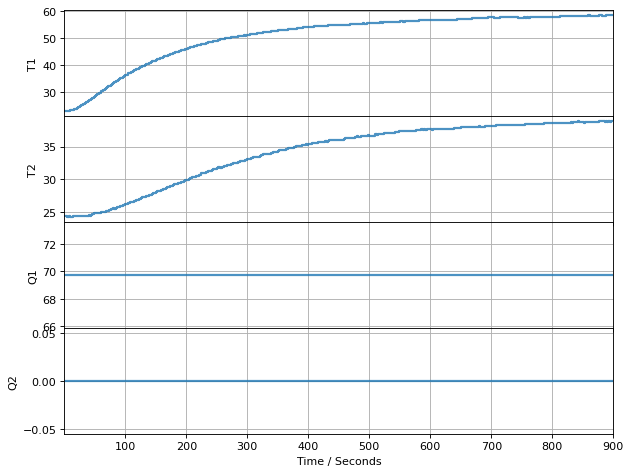

TCLab disconnected successfully.


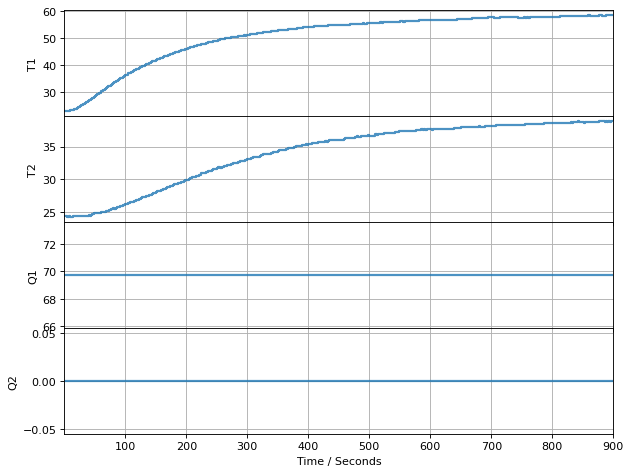

In [72]:
with TCLab() as lab:
    lab.P1 = P1
    lab.P2 = P2
    h = Historian(lab.sources)
    p = Plotter(h,t_final)
    for t in clock(t_final):
        lab.U1 = u_diff.value[0]
        lab.U2 = u_diff.value[1]
        p.update(t)

The estimate for this was very good.  While the optimization prediction was a degree or two above the real final temperature values, the very slight upward trend in the data after 15 minutes suggests that it is potentially possible steady state was not completely reached in that time, and the final predicted temperatures (60C for T1, 39.8C for T2) are potentially attainable.  The optimization model is not perfect, but it is a good predictor of the rough behavior of the TCLab.

I do want to note that I chose not to sample past 15 minutes because I did not believe I would learn substantially more from running a 20 or 30 minute sample and verifying the exact value of steady state.  It is possible to see the trend in the data and that the model was fairly accurate after 15 minutes.